실전기계 학습 Face Age Estimation

한정된 parameter에서 최고의 성능을 높이는 competition이었다.

시도한 방법은

1. 다양한 모델 (ResNet, Pre-Activation ResNet, WideResNet)

2. kfold

3. bsconv(경량화 conv 사용)

4. ensemble

5. optimizer 변경 (radam, adam, sgd)

6. 스케쥴러 변경 (CosineAnnealingWarmupRestarts, multi step etc)

7. 전처리 (dataset balance를 위해 upsample)

8. data augmentation, albumentations 사용

그중 3번 4번 8번이 가장 효과가 좋았다.




In [ ]:
!nvidia-smi

Sat Jun 12 07:48:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ./dataset
!unzip /content/drive/MyDrive/FaceAge.zip -d ./dataset

##**Import all neceassary packages**


In [ ]:
!pip install --upgrade bsconv
!pip install -U albumentations
!pip install pytorchcv torch>=0.4.0


     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 38.2MB 1.3MB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import os
import sys
import time
import torch
import numpy as np
from glob import glob
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.notebook import tqdm as tqdm

from sklearn.model_selection import KFold
import bsconv.pytorch
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2



##**Utils**

In [ ]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


# def accuracy(output, target, topk=(1,)):
#     r"""Computes the accuracy over the $k$ top predictions for the specified values of k
#     """
#     with torch.no_grad():
#         maxk = max(topk)
#         batch_size = target.size(0)

#         # _, pred = output.topk(maxk, 1, True, True)
#         # pred = pred.t()
#         # correct = pred.eq(target.view(1, -1).expand_as(pred))

#         # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
#         _, idx = output.sort(descending=True)
#         pred = idx[:,:maxk]
#         pred = pred.t()
#         correct = pred.eq(target.view(1, -1).expand_as(pred))

#         res = []
#         for k in topk:
#             correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
#             res.append(correct_k.mul_(100.0 / batch_size))
#         return res

In [ ]:
import random
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [ ]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
import math
import torch
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmupRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """
    
    def __init__(self,
                 optimizer : torch.optim.Optimizer,
                 first_cycle_steps : int,
                 cycle_mult : float = 1.,
                 max_lr : float = 0.1,
                 min_lr : float = 0.001,
                 warmup_steps : int = 0,
                 gamma : float = 1.,
                 last_epoch : int = -1
        ):
        assert warmup_steps < first_cycle_steps
        
        self.first_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle_mult = cycle_mult # cycle steps magnification
        self.base_max_lr = max_lr # first max learning rate
        self.max_lr = max_lr # max learning rate in the current cycle
        self.min_lr = min_lr # min learning rate
        self.warmup_steps = warmup_steps # warmup step size
        self.gamma = gamma # decrease rate of max learning rate by cycle
        
        self.cur_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle = 0 # cycle count
        self.step_in_cycle = last_epoch # step size of the current cycle
        
        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)
        
        # set learning rate min_lr
        self.init_lr()
    
    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)
    
    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) \
                    * (1 + math.cos(math.pi * (self.step_in_cycle-self.warmup_steps) \
                                    / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch
                
        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [ ]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

##**Parameter Settings**

In [ ]:
batch_size = 32  # Input batch size for training (default: 128)
epochs = 100 # Number of epochs to train (default: 100)
print_freq = 200
num_workers = 4
train_size = 0.9 #valid 10%
patience = 8
image_size = 48
seed_everything(84465)

##**Load and preprocess data**

In [ ]:

train_transform = A.Compose(
    [
        A.Resize(image_size, image_size), 
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

        A.CoarseDropout(max_holes= 4,max_height=8,max_width=8),
        # A.RandomGamma(),
        # A.GridDistortion(distort_limit=(-0.3, 0.3), border_mode=cv2.BORDER_CONSTANT, p=0.5),
        A.ElasticTransform(alpha_affine=2, border_mode=cv2.BORDER_CONSTANT, p=0.5),

        # A.geometric.rotate.Rotate(limit=30),
        ToTensorV2(),
    ]
)




test_transform = A.Compose(
    [
         A.Resize(48, 48), 
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
from torch.utils.data import Dataset,Subset


class FacialDataset(Dataset):
    def __init__(self, data_path,transform):
        if not os.path.exists(data_path):
            raise Exception(f"[!] {data_path} not existed")

        self.transform = transform
        self.data_path = data_path
        self.age_path = sorted(glob(os.path.join(data_path, "*.*")))
    def __getitem__(self, idx):
        image_filepath = self.age_path[idx]

        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = int(image_filepath.split('_')[0].split('/')[-1])


        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label



    def __len__(self):
        return len(self.age_path)

data_path ="/content/dataset/train"
train_dataset = FacialDataset(data_path,train_transform)
valid_dataset = FacialDataset(data_path,test_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[:split], indices[split:]

traindata = Subset(train_dataset, indices=train_idx)
valdata = Subset(valid_dataset, indices=valid_idx)


train_loader = torch.utils.data.DataLoader(dataset=traindata,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=valdata,batch_size=batch_size,shuffle=False)


In [ ]:
train_loader.sampler

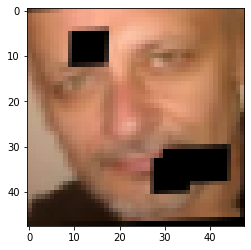

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image
%matplotlib inline

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images[0],nrow=20))

##**Main Training**

In [ ]:
def train(train_loader, epoch, model, optimizer):
    batch_time = AverageMeter('Time', ':6.3f')
    l2 = AverageMeter('L2 Loss', ':.4f')
    rmse = AverageMeter('RMSE Loss', ':.4f')
    progress = ProgressMeter(len(train_loader), batch_time, l2,rmse, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()
    l2_criterion = nn.MSELoss().cuda()
    end = time.time()
    for i, (input, label) in enumerate(train_loader):
        # measure data loading time
        input = input.float().cuda()
        label = label.float().flatten().cuda()

        # compute output
        output = model(input).flatten()
  
        loss = l2_criterion(output, label)
        rmse_loss = torch.sqrt(loss)


        #BSconv-s
        # loss +=model.reg_loss(alpha=0.1)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        rmse_loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        #loss updaet
        l2.update(loss.item(), input.size(0))
        rmse.update(rmse_loss.item(), input.size(0))
        

        if i % print_freq == 0:
            progress.print(i)



    

def validation(val_loader,epoch, model):
    print("Vlaid ",end="")
    model.eval()
    l2_criterion = nn.MSELoss().cuda()

    l2 = AverageMeter('L2 Loss', ':.4f')
    rmse = AverageMeter('RMSE Loss', ':.4f')
    progress = ProgressMeter(len(val_loader), l2,rmse,  prefix="Epoch: [{}]".format(epoch))

    correct = 0

    with torch.no_grad():

      for i,(input,label) in enumerate(val_loader):
          input = input.float().cuda()
          label = label.float().flatten().cuda()
          output = model(input).flatten()
          l2_ = l2_criterion(output, label)
          table = (torch.round(output) == label)
          correct += (table).float().sum()
          l2.update(l2_.item(), input.size(0))
          rmse.update(torch.sqrt(l2_).item(), input.size(0))

      progress.print(len(val_loader))
      return rmse.avg


## train

In [ ]:


model  = bsconv.pytorch.get_model('cifar_wrn40_4_bsconvu', num_classes=1).cuda()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    patience=2,
    factor=0.5,
    verbose=True
    )


pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {pytorch_total_params}")
if int(pytorch_total_params) > 2000000:
    print('Your model has the number of parameters more than 2 millions..')
    sys.exit()

loss = 1e5
_patience = 0

for epoch in range(epochs):
    print("\n----- epoch: {}, lr: {} -----".format(
        epoch, optimizer.param_groups[0]["lr"]))

    # train for one epoch
    start_time = time.time()

    train(train_loader, epoch, model, optimizer)
    val_loss = validation(val_loader,epoch,model)


    elapsed_time = time.time() - start_time
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))
    # learning rate scheduling
    scheduler.step(val_loss)
    
    # Save model for best 
    if loss > val_loss:
        loss = val_loss
        print(f"Best model save | loss : {loss:.4f}")
        torch.save(model.state_dict(), 'model_best.pt')
        _patience = 0
    else:
        _patience += 1
        if _patience > patience - 1:
            print('=======' * 10)
            print("[Info message] Early stopper is activated")
            break

    torch.save(model.state_dict(),'model_latest.pt')
print(f"Best RMSE loss: {loss}")


## Make an evalutation csv file

This code makes an evaluation csv file for Competition submission.

**Don't change below code!!!**

In [ ]:
class FacialDataset_test(Dataset):
    def __init__(self, data_path,transform):
        if not os.path.exists(data_path):
            raise Exception(f"[!] {data_path} not existed")

        self.transform = transform
        self.data_path = data_path
        self.age_path = sorted(glob(os.path.join(data_path, "*.*")))
    def __getitem__(self, idx):
        image_filepath = self.age_path[idx]

        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image



    def __len__(self):
        return len(self.age_path)


import torch
import pandas as pd
import argparse
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from google.colab import files



def eval():
    test_dataset = FacialDataset_test("/content/dataset/test",test_transform)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1,shuffle=False)

    model  = bsconv.pytorch.get_model('cifar_wrn40_4_bsconvu', num_classes=1).cuda()
  
    model.load_state_dict(torch.load('/content/model_best.pt'))
    model.eval()
    
    print('Make an evaluation csv file for submission...')
    Category = []
    for input in test_loader:
        input = input.float().cuda()
        output = [model(input).item()]
        # output = torch.argmax(output, dim=1)
        Category = Category + output

    Id = list(range(0, len(test_loader)))
    samples = {
       'Id': Id,
       'Category': Category 
    }
    df = pd.DataFrame(samples, columns=['Id', 'Category'])

    df.to_csv('/content/submission_best.csv', index=False)
    print('Done!!')

  
if __name__ == "__main__":
    eval()
    files.download('submission_best.csv') 
    files.download('model_best.pt') 


Make an evaluation csv file for submission...
Done!!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>